In [17]:
import numpy as np
import argparse
from tensorflow.keras import initializers, layers

import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,InputLayer,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU
from tensorflow.keras.layers import Flatten
# load model without classifier layers
from tensorflow.keras.applications import VGG19

from tensorflow.keras.applications import VGG19
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import re 
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import pandas as pd
print(tf.__version__)
import argparse
import os
import sys, os
from facenet_pytorch import MTCNN
from PIL import Image
import torch
import glob
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
# load model without classifier layers
from tensorflow.keras.applications import VGG19



2.3.0


# Capsule Layers 
Here is the implementation of the necessary layers for the CapsuleNet. These are not optimized yet and can be made significantly more performant. 

In [2]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))

        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)

            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:

                b += tf.matmul(outputs, inputs_hat, transpose_b=True)

        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)



In [5]:

K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, routings, batch_size):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :param batch_size: size of batch
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """

    """
    """
    x = layers.Input(shape=input_shape, batch_size=batch_size)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16 * n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model

In [6]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    # return tf.reduce_mean(tf.square(y_pred))
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))

    return tf.reduce_mean(tf.reduce_sum(L, 1))

In [24]:
def train(model, data):
#def train(model, train_gen, val_gen,args):

    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # compile the model
    model.compile(optimizer=optimizers.Adam(0.001),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.392],
                  metrics={'capsnet': 'accuracy'})


    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction) 
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield (x_batch, y_batch), (y_batch, x_batch)

    model.fit(train_generator(x_train, y_train, batch_size),
              steps_per_epoch=int(np.shape(y_train)[0] / batch_size),
              epochs=epochs,
              validation_data=((x_test, y_test), (y_test, x_test)), batch_size=batch_size)
    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)


    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

    return model


In [8]:
epochs = 20
batch_size = 10
lr_decay = 0.9
routings = 1
shift_fraction = 0.1

In [9]:
DATASET_PATHS = {"original":"/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/Original_images/",
    "Deepfakes": "/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/Mainpulated_images/"
}


In [10]:
Processed_datasets = {
    'train_dir': 'D:\\base__dir\\train_dir\\',
    'val_dir': 'D:\\base__dir\\val_dir\\'
}

In [11]:
df_train = pd.read_csv("C:\\Users\\Dio Gado\\Asmaa\\Minerva_Capstone\\Preprocess Data\\train_data_csv.csv")
df_val = pd.read_csv("C:\\Users\\Dio Gado\\Asmaa\\Minerva_Capstone\\Preprocess Data\\val_data_csv.csv")


In [12]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [14]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(Processed_datasets['train_dir'],
                                        target_size=(300,300),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(Processed_datasets['train_dir'],
                                        target_size=(300,300),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

Found 4800 images belonging to 2 classes.
Found 4800 images belonging to 2 classes.


In [20]:
class_mode='binary'
from itertools import zip_longest as izip
x_tran, y_tran = izip(*(val_gen[i] for i in range(len(train_gen))))
x_tran = np.vstack(x_tran)
y_tran = np.vstack(map(to_categorical, y_tran))[:,0] if class_mode == 'binary' else y


In [15]:
#from itertools import izip, imap
class_mode='binary'
from itertools import zip_longest as izip
x, y = izip(*(val_gen[i] for i in range(len(val_gen))))
x_val = np.vstack(x)
y_val = np.vstack(map(to_categorical, y))[:,0] if class_mode == 'binary' else y


In [18]:
model, eval_model, manipulate_model = CapsNet(input_shape=(300,300,3),n_class=2,routings=routings,                    batch_size=batch_size)
model.summary()



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(10, 300, 300, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (10, 292, 292, 256)  62464       input_2[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (10, 142, 142, 256)  5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (10, 645248, 8)      0           primarycap_conv2d[0][0]          
_______________________________________________________________________________________

In [26]:
train(model=model, data=((x_tran, y_tran), (x_val, y_val)))


Epoch 1/50


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_1/conv1/Relu (defined at <ipython-input-24-89cc37b75500>:32) ]] [Op:__inference_train_function_2657]

Function call stack:
train_function


In [104]:
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(300, 300, 3))

In [117]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [106]:
conv = Sequential()

for layer in conv_base.layers[:18]: # this is where I changed your code
    conv.add(layer)    

# Freeze the layers 
for layer in conv.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.


In [107]:
conv.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 75, 75, 256)      

In [108]:
batch_size = 10
datagen = ImageDataGenerator(rescale=1./255)
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 18, 18, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(300, 300),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [34]:
train_dir = '/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/base_dir/train_dir'
validation_dir = '/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/Capstone/Alternative_data/base_dir/val_dir'

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 0.6221 - capsnet_loss: 0.2469 - decoder_loss: 0.9571 - capsnet_accuracy: 0.4875
Epoch 00001: val_capsnet_accuracy improved from -inf to 0.50000, saving model to ./result/weights-01.h5
16/16 [==============================] - 20s 1s/step - loss: 0.6221 - capsnet_loss: 0.2469 - decoder_loss: 0.9571 - capsnet_accuracy: 0.4875 - val_loss: 0.6275 - val_capsnet_loss: 0.2131 - val_decoder_loss: 1.0571 - val_capsnet_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.5840 - capsnet_loss: 0.2165 - decoder_loss: 0.9377 - capsnet_accuracy: 0.4375
Epoch 00002: val_capsnet_accuracy did not improve from 0.50000
16/16 [==============================] - 18s 1s/step - loss: 0.5840 - capsnet_loss: 0.2165 - decoder_loss: 0.9377 - capsnet_accuracy: 0.4375 - val_loss: 0.6031 - val_capsnet_loss: 0.2132 - val_decoder_loss: 0.9946 - val_capsnet_accuracy: 0.5000 - lr: 9.0000e-04
Epoch 3/10
16/16 

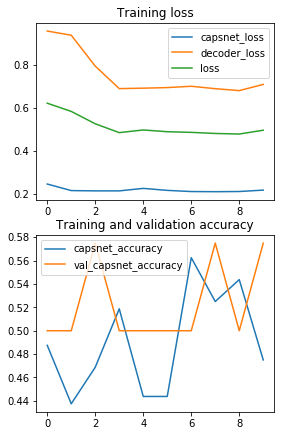

Trained model saved to './result/trained_model.h5'


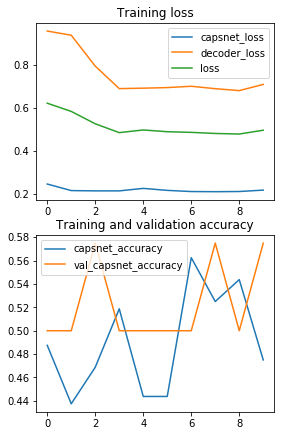

In [129]:
train(model=model, data=((train_features, y_tran), (validation_features, y_val)), args=args)

In [174]:
train(model=model, data=((x_tran, y_tran), (x_val, y_val)), args=args)


NameError: name 'x_tran' is not defined

In [ ]:
model, eval_model, manipulate_model = CapsNet(input_shape=(18,18,512),n_class=2,routings=routings,                    batch_size=args.batch_size)
model.summary()


In [ ]:
train(model=model, data=((train_features, y_tran), (validation_features, y_val)), args=args)
train_features, train_labels = extract_features(train_dir, num_train_samples)
validation_features, validation_labels = extract_features(validation_dir, num_val_samples)